In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from tqdm import tqdm

# Load data

In [3]:
def bootstrapped(data,n_resamples = 20):
    data = (data,)
    bootstrap_ci = scipy.stats.bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return np.abs(bootstrap_ci.confidence_interval[1] - np.mean(data))

In [4]:
def set_fig_(ax , xlabel=0, ylabel=0 , xlog=0, ylog=0, fontsize=16, iflegend=0 , ncol=1, legendloc=2,color = 'k'):
    if xlabel!=0:
        ax.set_xlabel(xlabel,size = fontsize)
    else:
        ax.set_xlabel('')
    if ylabel!=0:
        ax.set_ylabel(ylabel,size = fontsize,color =color)
    else:
        ax.set_ylabel('')
    if ylog:
        ax.set_yscale("log")
    if xlog:
        ax.set_xscale("log")
    if iflegend==1:
        ax.legend(frameon =False,fontsize = 14, loc=legendloc)
    if iflegend==2:
        ax.legend(frameon =False,fontsize = fontsize,ncol=ncol,bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14,labelcolor =color)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)

In [5]:
df = pd.read_csv(r"E:\Data\Patent\KPSS\TextInnovation.csv.zip")
df['KI5'] = np.log(df['fsim5']/df['bsim5'])
for col in ['bsim5', 'fsim1', 'fsim5','fsim10', 'np_b5', 'np_f1', 'np_f5', 'np_f10']:
    del df[col]
df = df[df['filed_year'].isin(range(1980,2018))].reset_index(drop=True)

cd = pd.read_csv(r"E:\Data\Patent\KPSS\citations\Disruption.csv.zip")
cd['CD5'] = (cd['D5']-cd['C5'])/(cd['D5']+cd['C5']+cd['R5'])
df['CD5'] = df['patent_id'].map(cd.set_index('patent_id')['CD5'])

df['CD5_pct'] = df['CD5'].rank() / len(df['CD5'].dropna()) * 100
df['KI5_pct'] = df['KI5'].rank() / len(df['KI5'].dropna()) * 100

df['top10_ki'] = 0
df.loc[df['KI5_pct']>90 , 'top10_ki'] = 1
df['top5_cd'] = 0
df.loc[df['CD5_pct']>90 , 'top5_cd'] = 1

In [6]:
teamsize = pd.read_csv(r"E:\Data\Patent\Patent\Team\TeamSize.csv.zip")

df['n_au'] = df['patent_id'].map(teamsize.set_index('patent_id')['n_au'])

df['n_au2'] = df['n_au'].apply(lambda x:x if x<10 else 10)

In [7]:
dfc = df[df['n_au']>=2].reset_index(drop=True)
distance = pd.read_csv(r"E:\Data\Patent\Patent\Team\patentAffDistance2.csv.zip")

dfc['distance'] = dfc['patent_id'].map(distance.set_index('patent_id')['AvgGeography_affiliation'])
dfc['distance'] = dfc['distance'].fillna(0)

dfc['mid_distance'] = dfc['patent_id'].map(distance.set_index('patent_id')['MedianGeography_affiliation'])
dfc['mid_distance'] = dfc['mid_distance'].fillna(0)

bins = [-float('inf'), 0, 20, 50, 100, 500, float('inf')]
labels = [0, 1, 2, 3, 4, 5]
dfc['distance2'] = pd.cut(dfc['distance'], bins=bins, labels=labels, right=True)
dfc['mid_distance2'] = pd.cut(dfc['mid_distance'], bins=bins, labels=labels, right=True)

# Line plot

In [8]:
d1 = df.groupby('n_au2')['KI5'].mean().reset_index()
ci1 = df.dropna(subset=['n_au2','KI5']).groupby('n_au2')['KI5'].apply(bootstrapped).reset_index()

d2 = df.groupby('n_au2')['CD5'].mean().reset_index()
ci2 = df.dropna(subset=['n_au2','CD5']).groupby('n_au2')['CD5'].apply(bootstrapped).reset_index()

In [9]:
d1_ = dfc.groupby('distance2')['KI5'].mean().reset_index()
ci1_ = dfc.dropna(subset=['distance2','KI5']).groupby('distance2')['KI5'].apply(bootstrapped).reset_index()

d2_ = dfc.groupby('distance2')['CD5'].mean().reset_index()
ci2_ = dfc.dropna(subset=['distance2','CD5']).groupby('distance2')['CD5'].apply(bootstrapped).reset_index()

C:\Users\nd\AppData\Local\Temp\ipykernel_7032\3894016122.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_ = dfc.groupby('distance2')['KI5'].mean().reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\3894016122.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci1_ = dfc.dropna(subset=['distance2','KI5']).groupby('distance2')['KI5'].apply(bootstrapped).reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\3894016122.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [10]:
d1__ = dfc.groupby('mid_distance2')['KI5'].mean().reset_index()
ci1__ = dfc.dropna(subset=['mid_distance2','KI5']).groupby('mid_distance2')['KI5'].apply(bootstrapped).reset_index()

d2__ = dfc.groupby('mid_distance2')['CD5'].mean().reset_index()
ci2__ = dfc.dropna(subset=['mid_distance2','CD5']).groupby('mid_distance2')['CD5'].apply(bootstrapped).reset_index()

C:\Users\nd\AppData\Local\Temp\ipykernel_7032\591913933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1__ = dfc.groupby('mid_distance2')['KI5'].mean().reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\591913933.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci1__ = dfc.dropna(subset=['mid_distance2','KI5']).groupby('mid_distance2')['KI5'].apply(bootstrapped).reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\591913933.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current b

In [11]:
def draw(ax , d1 , ci1 , d3 , ci3 , xlabel , ylabel1 , ylabel2):
    color='#922B21'
    col1 = d1.columns[0]
    col2 = d1.columns[1]
    plt.plot(d1[col1].values , d1[col2].values , color=color , lw=2)
    plt.plot(d1[col1].values , d1[col2].values+ci1[col2].values , color=color, ls='--' , lw=.5)
    plt.plot(d1[col1].values , d1[col2].values-ci1[col2].values , color=color, ls='--' , lw=.5)
    set_fig_(ax, xlabel, ylabel1, 0, 0, iflegend=0,color = color)
    
    color='#138D75'
    ax_ = ax.twinx()
    col1 = d3.columns[0]
    col2 = d3.columns[1]
    plt.plot(d3[col1].values , d3[col2].values , color=color , lw=2)
    plt.plot(d3[col1].values , d3[col2].values+ci3[col2].values , color=color, ls='--' , lw=.5)
    plt.plot(d3[col1].values , d3[col2].values-ci3[col2].values , color=color, ls='--' , lw=.5)
    set_fig_(ax_, xlabel, ylabel2, 0, 0, iflegend=0,color = color)

In [12]:
p1 = df.groupby('n_au2')['top10_ki'].mean().reset_index()
p1['top10_ki'] = p1['top10_ki'] / df['top10_ki'].mean()
p1_ = dfc.groupby('distance2')['top10_ki'].mean().reset_index()
p1_['top10_ki'] = p1_['top10_ki'] / dfc['top10_ki'].mean()
p1__ = dfc.groupby('mid_distance2')['top10_ki'].mean().reset_index()
p1__['top10_ki'] = p1__['top10_ki'] / dfc['top10_ki'].mean()

p2 = df.groupby('n_au2')['top5_cd'].mean().reset_index()
p2['top5_cd'] = p2['top5_cd'] / df['top5_cd'].mean()
p2_ = dfc.groupby('distance2')['top5_cd'].mean().reset_index()
p2_['top5_cd'] = p2_['top5_cd'] / dfc['top5_cd'].mean()
p2__ = dfc.groupby('mid_distance2')['top5_cd'].mean().reset_index()
p2__['top5_cd'] = p2__['top5_cd'] / dfc['top5_cd'].mean()

C:\Users\nd\AppData\Local\Temp\ipykernel_7032\1584847444.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p1_ = dfc.groupby('distance2')['top10_ki'].mean().reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\1584847444.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p1__ = dfc.groupby('mid_distance2')['top10_ki'].mean().reset_index()
C:\Users\nd\AppData\Local\Temp\ipykernel_7032\1584847444.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

In [24]:
def draw_(ax , d1 , d3 , xlabel , ylabel1 , ylabel2 , iflegend=0):
    color='#922B21'
    col1 = d1.columns[0]
    col2 = d1.columns[1]
    plt.plot(d1[col1].values , d1[col2].values , color=color , lw=2 , marker = 'o', label = ylabel1)
    
    color='#138D75'
    col1 = d3.columns[0]
    col2 = d3.columns[1]
    plt.plot(d3[col1].values , d3[col2].values , color=color , lw=2 , marker = 'o' , label = ylabel2)
    plt.axhline(y=1,color='grey',ls='--')
    set_fig_(ax, xlabel, 'Relative ratio', 0, 0, iflegend=iflegend, legendloc=1)

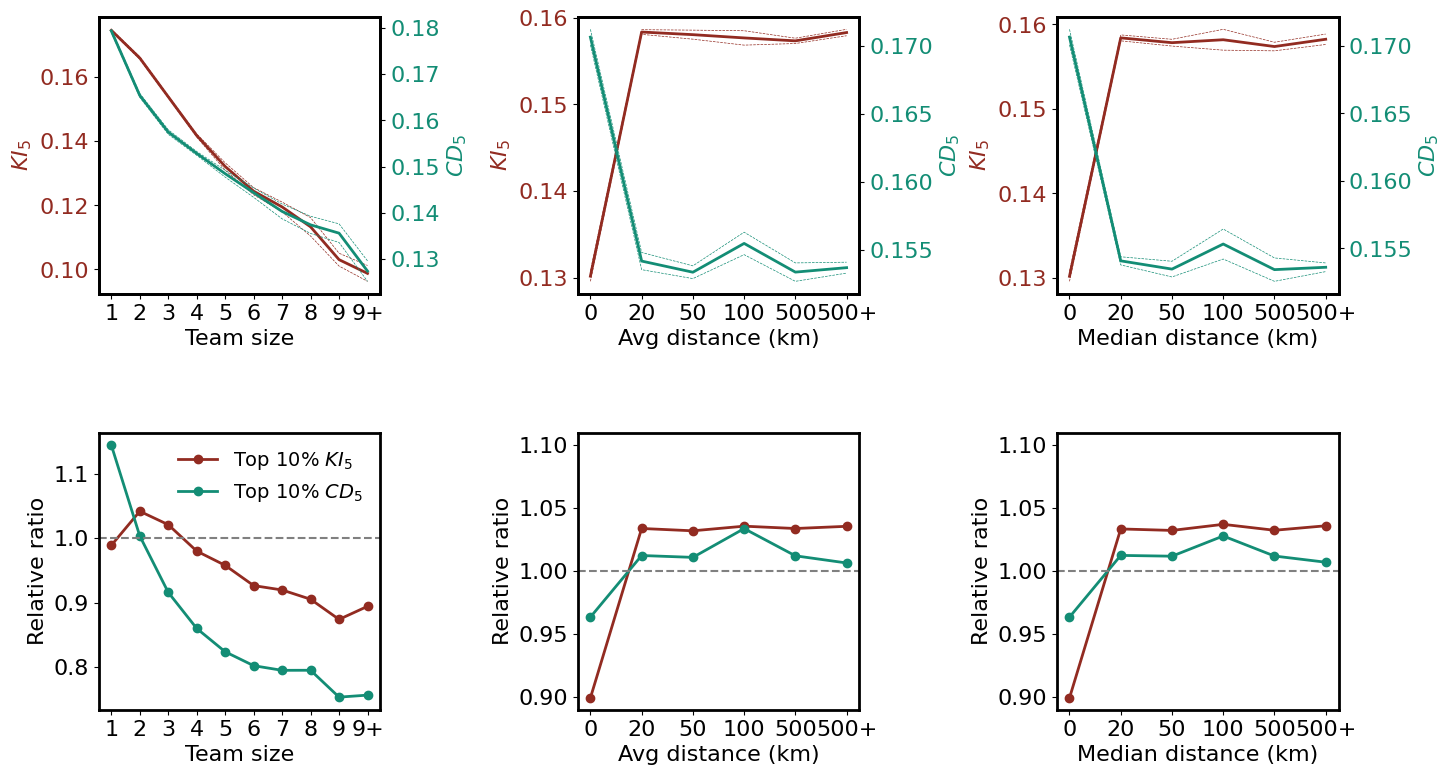

In [26]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

ax = fig.add_subplot(gs[0])
draw(ax , d1 , ci1 , d2 , ci2 , 'Team size', '$KI_5$', '$CD_5$')
plt.xticks([1,2,3,4,5,6,7,8,9,10],['1','2','3','4','5','6','7','8','9','9+'])

ax = fig.add_subplot(gs[1])
draw(ax , d1_ , ci1_ , d2_ , ci2_ , 'Avg distance (km)', '$KI_5$', '$CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])

ax = fig.add_subplot(gs[2])
draw(ax , d1__ , ci1__ , d2__ , ci2__ , 'Median distance (km)', '$KI_5$', '$CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])

ax = fig.add_subplot(gs[3])
draw_(ax , p1 , p2 , 'Team size', 'Top 10% $KI_5$', 'Top 10% $CD_5$', iflegend=1)
plt.xticks([1,2,3,4,5,6,7,8,9,10],['1','2','3','4','5','6','7','8','9','9+'])

ax = fig.add_subplot(gs[4])
draw_(ax , p1_ , p2_ , 'Avg distance (km)', 'Top 10% $KI_5$', 'Top 10% $CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])
plt.ylim(0.89,1.11)

ax = fig.add_subplot(gs[5])
draw_(ax , p1__ , p2__ , 'Median distance (km)', 'Top 10% $KI_5$', 'Top 10% $CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])
plt.ylim(0.89,1.11)
plt.savefig(savepath + "Team.svg",bbox_inches = 'tight')

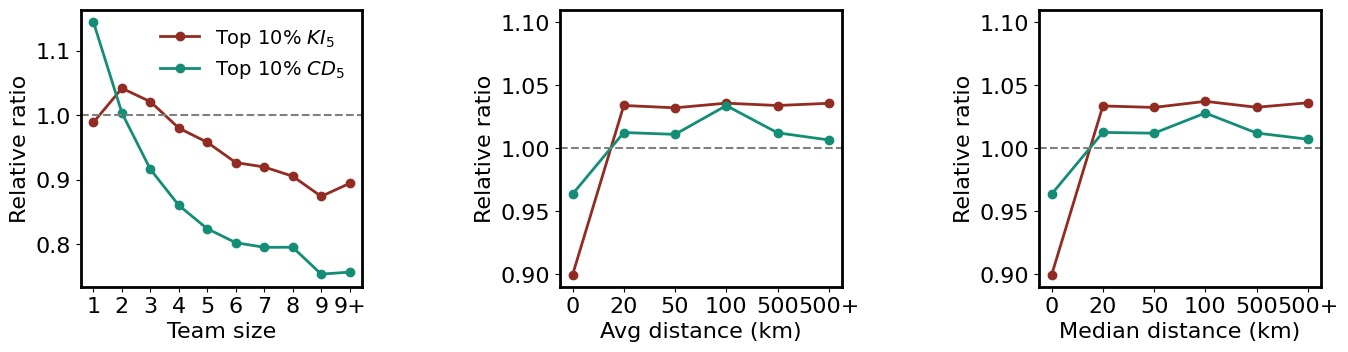

In [27]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)
ax = fig.add_subplot(gs[3])
draw_(ax , p1 , p2 , 'Team size', 'Top 10% $KI_5$', 'Top 10% $CD_5$', iflegend=1)
plt.xticks([1,2,3,4,5,6,7,8,9,10],['1','2','3','4','5','6','7','8','9','9+'])

ax = fig.add_subplot(gs[4])
draw_(ax , p1_ , p2_ , 'Avg distance (km)', 'Top 10% $KI_5$', 'Top 10% $CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])
plt.ylim(0.89,1.11)

ax = fig.add_subplot(gs[5])
draw_(ax , p1__ , p2__ , 'Median distance (km)', 'Top 10% $KI_5$', 'Top 10% $CD_5$')
plt.xticks([0, 1, 2, 3,4, 5],[0,20,50,100,500,'500+'])
plt.ylim(0.89,1.11)
plt.savefig(savepath + "Team_.svg",bbox_inches = 'tight')